In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import optax
from flax import nnx
import orbax.checkpoint as ocp

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt
from jax.experimental.ode import odeint

import jaxpm
from jaxpm import camels, plotting, pm, hpm, nn
from jaxpm.painting import cic_paint, cic_read
from jaxpm.nn import MLP, NeuralSplineFourierFilter

from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel

jax.devices("gpu")

[cuda(id=0)]

# configuration

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

# CAMELS

In [4]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"

out_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    # i_snapshots=[0, -1],
    i_snapshots=range(1, 33+4, 4),
    return_hydro=True,
)

cosmo = out_dict["cosmo"]
scales = out_dict["scales"]

dm_poss = out_dict["dm_poss"]
dm_vels = out_dict["dm_vels"]

gas_poss = out_dict["gas_poss"]
gas_vels = out_dict["gas_vels"]

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_018.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_034.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_042.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_050.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_058.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_066.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_074.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_082.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 9/9 [01:33<00:00, 10.44s/it]


# reference PM simulation

In [5]:
# resi = odeint(make_ode_fn(mesh_shape), [dm_poss[0], dm_vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

# pm_dm_poss = resi[0]
# pm_dm_vels = resi[1]

# neural HPM simulation

In [6]:
# import haiku as hk
# rng_seq = hk.PRNGSequence(1)

# model = hk.without_apply_rng(hk.transform(lambda x,a : nn.NeuralSplineFourierFilter()(x,a)))
# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

# # kvec = fftk(mesh_shape)
# # k = jnp.sqrt(sum((ki/jnp.pi)**2 for ki in kvec))
# # a = scales[0]
# # hk_out = hk_model.apply(params, k, jnp.atleast_1d(a))

In [30]:
model = nn.NeuralSplineFourierFilterNNX(n_knots=8, d_latent=16, rngs=nnx.Rngs(0))

In [31]:
learning_rate = 1e-2
clip_norm = 1

optimizer = nnx.Optimizer(
    model,
    optax.chain(
        optax.clip_by_global_norm(clip_norm),
        optax.adam(learning_rate)
    )
)

# nnx.jit

In [32]:
ref_pos = gas_poss
ref_vel = gas_vels

# ref_pos = dm_poss
# ref_vel = dm_vels

# optimizer = nnx.Optimizer(model, adam)

@nnx.jit
def train_step(model, optimizer):

    def loss_fn(model):
        res = odeint(
            hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, force_type="direct"), 
            [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]],
            scales,
            rtol=1e-3, 
            atol=1e-3
        )
        distance = jnp.sum((res[2] - ref_pos)**2, axis=-1)
        # distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)

        vel = jnp.sum((res[3] - ref_vel)**2, axis=-1)
        # vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)

        w = jnp.where(distance < 100, distance, 0.)
        wv = jnp.where(distance < 100, vel, 0.)
        
        return 0.01*jnp.mean(wv) + jnp.mean(w)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss



  0%|          | 0/100 [00:00<?, ?it/s]2024-11-27 16:03:36.162825: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %negate.907 = f32[9,262144,3]{2,1,0} negate(f32[9,262144,3]{2,1,0} %constant.131)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-27 16:03:38.300988: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.138265911s
Constant folding an instruction is taking > 4s:

  %negate.907 = f32[9,262144,3]{2,1,0} negate(f32[9,262144,3]{2,1,0} %constant.131)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation t

[None]

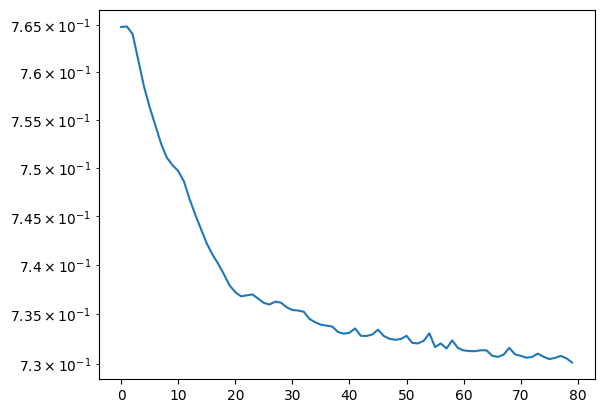

In [33]:
total_steps = 100
losses = []
for i in tqdm.tqdm(range(total_steps)):    
    loss = train_step(model, optimizer)
    losses.append(loss)

fig, ax = plt.subplots()
ax.plot(losses[20:])
ax.set(yscale="log")

# jax.jit

In [34]:
# graphdef, params = nnx.split(model)
# opt_state = adam.init(params)

# ref_pos = jnp.stack(gas_poss, axis=0)
# ref_vel = jnp.stack(gas_vels, axis=0)

# @jax.jit
# def train_step(params, opt_state):
#     def loss_fn(params):
#         res = odeint(
#             hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, force_type="direct"), 
#             [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]],
#             scales,
#             params,
#             rtol=1e-5, 
#             atol=1e-5
#         )
#         distance = jnp.sum((res[2] - ref_pos)**2, axis=-1)
#         vel = jnp.sum((res[3] - ref_vel)**2, axis=-1)
        
#         w = jnp.where(distance < 100, distance, 0.)
#         wv = jnp.where(distance < 100, vel, 0.)
        
#         return 0.01*jnp.mean(wv) + jnp.mean(w)
    
#     loss, grads = jax.value_and_grad(loss_fn)(params)

#     updates, opt_state = adam.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)

#     return params, opt_state, loss


In [35]:
# total_steps = 100

# losses = []
# for step in tqdm.tqdm(range(total_steps)):
#     params, opt_state, loss = train_step(params, opt_state)
#     losses.append(loss)

# model = nnx.merge(graphdef, params)

In [36]:
# fig, ax = plt.subplots()
# ax.plot(losses)
# ax.set()

# evaluation

In [39]:
hpm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint", force_type="direct")

res = odeint(hpm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-3, atol=1e-3)
hpm_dm_poss, hpm_dm_vels, hpm_gas_poss, hpm_gas_vels = res[0], res[1], res[2], res[3]

In [40]:
pm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint", gravity_only=True, force_type="direct")

res = odeint(pm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-3, atol=1e-3)
pm_dm_poss, pm_dm_vels, pm_gas_poss, pm_gas_vels = res[0], res[1], res[2], res[3]

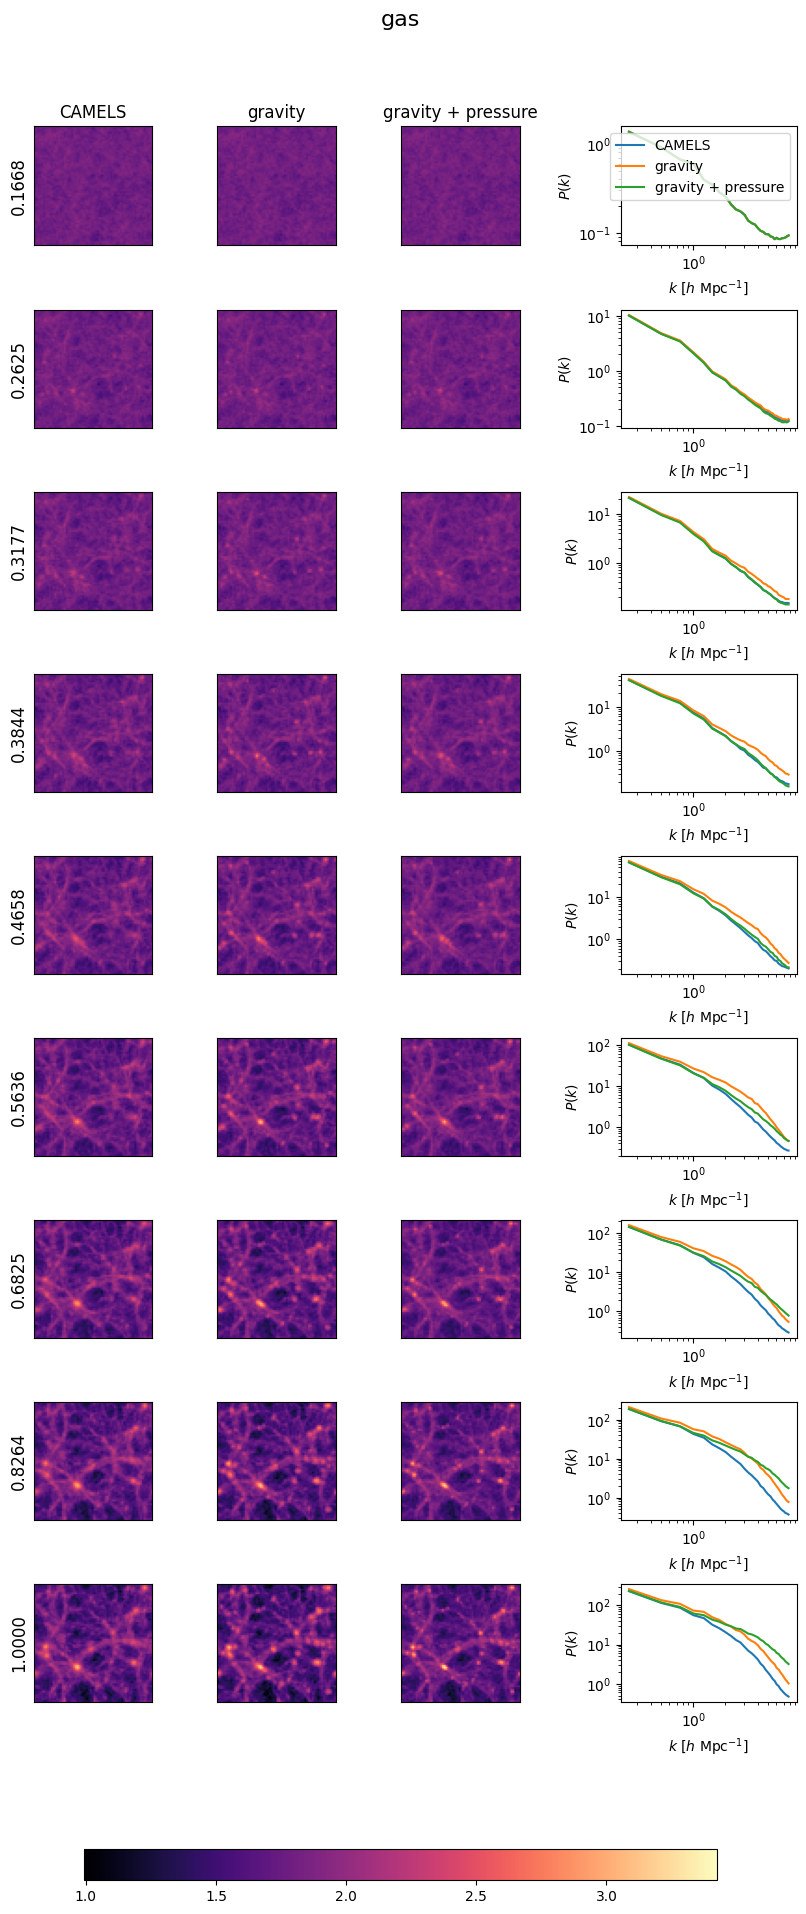

In [41]:
plotting.compare_particle_evolution(
    mesh_shape, 
    scales, 
    jnp.stack([gas_poss, pm_gas_poss, hpm_gas_poss], axis=0), 
    title="gas",
    col_titles=["CAMELS", "gravity", "gravity + pressure"],
    include_pk=True,
)

In [42]:
# res = odeint(
#     hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, force_type="direct"), 
#     [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]],
#     scales, 
#     rtol=1e-5, 
#     atol=1e-5
# ) 


In [43]:
# plotting.compare_particle_evolution(
#     mesh_shape, 
#     scales, 
#     jnp.stack([gas_poss, res[2]], axis=0), 
#     title="gas",
#     col_titles=["CAMELS", "hpm"],
#     include_pk=True,
# )

In [18]:
# scale = scales[0]
# dm_pos = dm_poss[0]
# dm_vel = dm_vels[0]
# gas_pos = gas_poss[0]
# gas_vel = gas_vels[0]
# kvec = fftk(mesh_shape)

# rho_dm = cic_paint(jnp.zeros(mesh_shape), dm_pos)
# rho_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, weight=cosmo.Omega_b / cosmo.Omega_c)
# rho_tot = rho_dm + rho_gas

# # gravitational potential
# rho_k_tot = jnp.fft.rfftn(rho_tot)
# phi_k = rho_k_tot * invlaplace_kernel(kvec)

# # pressure
# k = jnp.sqrt(sum((ki / jnp.pi) ** 2 for ki in kvec))

In [19]:
# def pressure(pos):
#     return jnp.stack(
#         [
#             cic_read(
#                 jnp.fft.irfftn(gradient_kernel(kvec, i) * phi_k * (1 + model(k, jnp.atleast_1d(scale)))),
#                 pos,
#             )
#             for i in range(len(kvec))
#         ],
#         axis=-1,
#     )

# print(pressure(gas_pos))

In [20]:
# def gravity(pos):
#     return jnp.stack(
#         [cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i) * phi_k), pos) for i in range(len(kvec))],
#         axis=-1,
#     )

# def pressure(pos):
#     return jnp.stack(
#         [
#             cic_read(
#                 jnp.fft.irfftn(gradient_kernel(kvec, i) * phi_k * model(k, jnp.atleast_1d(scale))),
#                 pos,
#             )
#             for i in range(len(kvec))
#         ],
#         axis=-1,
#     )

# print(gravity(gas_pos) + pressure(gas_pos))

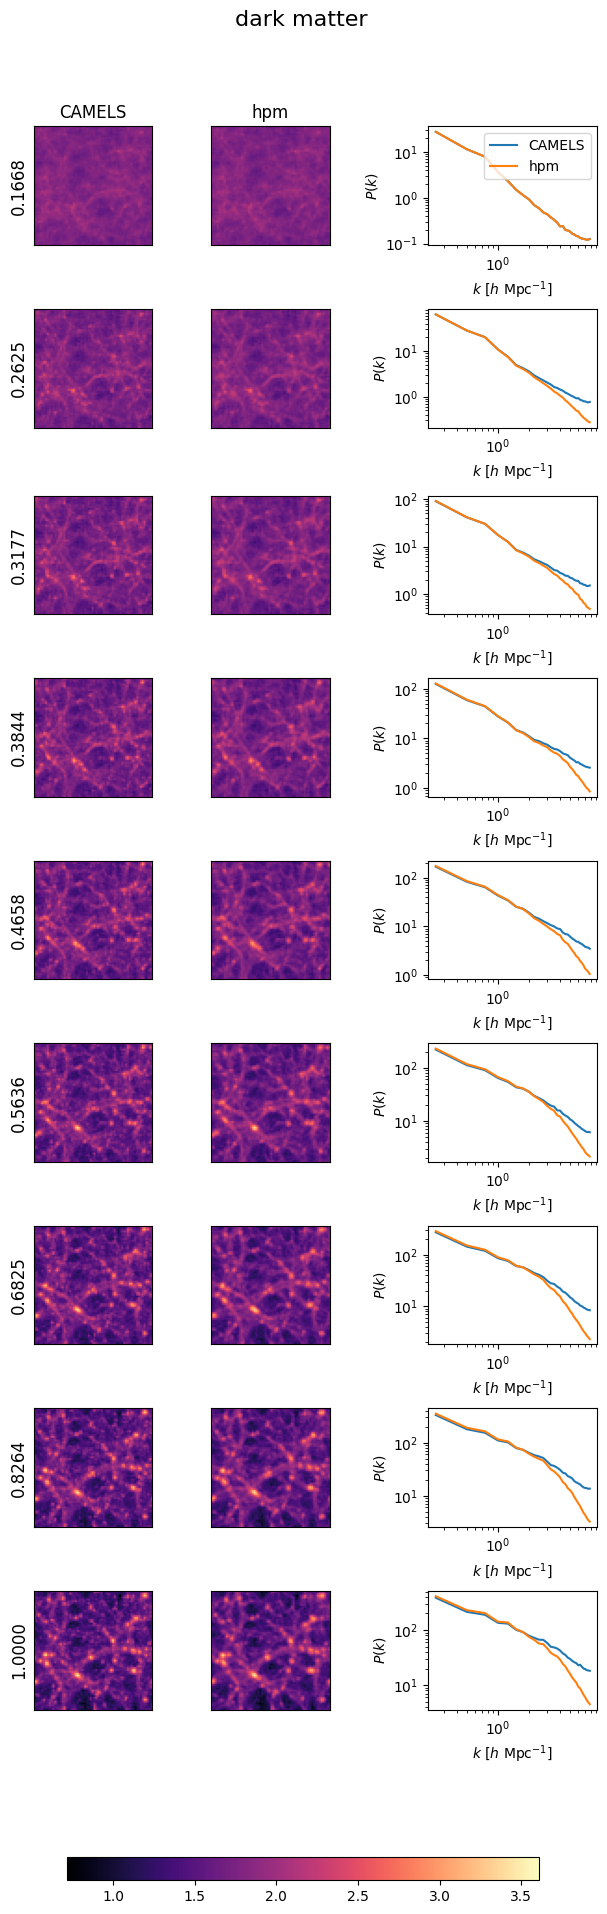

In [21]:
plotting.compare_particle_evolution(
    mesh_shape, 
    scales, 
    jnp.stack([dm_poss, res[0]], axis=0), 
    title="dark matter",
    col_titles=["CAMELS", "hpm"],
    include_pk=True,
)

# old

In [22]:
# ref_pos = gas_poss
# ref_vel = gas_vels

# def loss_fn(params):
#     res = odeint(
#         hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, force_type="direct"), 
#         [poss[0], vels[0]], 
#         jnp.array(scales), 
#         cosmo, 
#         params, 
#         rtol=1e-5, 
#         atol=1e-5
#     ) 
#     distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
#     vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
    
#     w = jnp.where(distance < 100, distance, 0.)
#     wv = jnp.where(distance < 100, vel, 0.)
    
#     return 0.01*jnp.mean(wv) + jnp.mean(w)


In [23]:
# hpm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint")

# res = odeint(hpm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-3, atol=1e-3)
# hpm_dm_poss, hpm_dm_vels, hpm_gas_poss, hpm_gas_vels = res[0], res[1], res[2], res[3]

In [24]:
# plotting.compare_particle_evolution(
#     mesh_shape, 
#     scales, 
#     jnp.stack([gas_poss, hpm_gas_poss], axis=0), 
#     title="gas",
#     col_titles=["CAMELS", "hpm"],
#     include_pk=True,
# )

In [25]:
# # @partial(jax.jit, static_argnums=[5, 6, 7, 8])
# # @partial(nnx.jit, static_argnums=[5, 6, 7, 8])
# def run_hpm(scales, dm_pos_i, dm_vel_i, gas_pos_i, gas_vel_i, cosmo, checkpoints=5, rtol=1e-3, atol=1e-3):
#     print("tracing the simulation")

#     res = diffeqsolve(
#         terms=ODETerm(hpm_ode),
#         solver=Dopri5(),
#         t0=scales[0],
#         t1=scales[-1],
#         dt0=0.01,
#         y0=jnp.stack([dm_pos_i, dm_vel_i, gas_pos_i, gas_vel_i], axis=0),
#         saveat=SaveAt(ts=scales),
#         adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints),
#         max_steps=100,
#         stepsize_controller=PIDController(rtol=rtol, atol=atol),
#     )

#     return res.ys[:,0], res.ys[:,1], res.ys[:,2], res.ys[:,3]

In [26]:
# vmin, vmax = plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, title="gas (CAMELS)", return_lims=True)
# plotting.plot_particle_evolution(mesh_shape, scales, hpm_gas_poss, title="gas (hpm)", vmin=vmin, vmax=vmax)

In [27]:
# plotting.compare_particle_evolution(
#     mesh_shape, 
#     scales, 
#     jnp.stack([dm_poss, pm_dm_poss, hpm_dm_poss], axis=0), 
#     title="dark matter",
#     col_titles=["CAMELS", "pm", "hpm"],
#     include_pk=True,
# )

In [28]:
# vmin, vmax = plotting.plot_particle_evolution(mesh_shape, scales, dm_poss, title="dark matter (CAMELS)", return_lims=True)
# plotting.plot_particle_evolution(mesh_shape, scales, pm_dm_poss, title="dark matter (pm)", vmin=vmin, vmax=vmax)
# plotting.plot_particle_evolution(mesh_shape, scales, hpm_dm_poss, title="dark matter (hpm)", vmin=vmin, vmax=vmax)

In [29]:
# def paint_log_sum(positions, weights=None):
#     return np.log10(cic_paint(jnp.zeros(mesh_shape), positions, weights).sum(axis=0))

# i_scale = -1

# nrows = 2
# ncols = 3
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

# # dark matter
# dm_field = paint_log_sum(dm_poss[i_scale])
# vmin, vmax = dm_field.min(), dm_field.max()
# im0 = ax[0,0].imshow(dm_field, vmin=vmin, vmax=vmax)
# im2 = ax[0,1].imshow(paint_log_sum(hpm_dm_poss[i_scale]), vmin=vmin, vmax=vmax)
# im1 = ax[0,2].imshow(paint_log_sum(ref_dm_poss[i_scale]), vmin=vmin, vmax=vmax)

# ax[0,0].set_ylabel("dark matter", fontsize=24)
# ax[0,0].set_title("CAMELS", fontsize=24)
# ax[0,1].set_title("hydro particle mesh", fontsize=24)
# ax[0,2].set_title("particle mesh", fontsize=24)
# cbar = fig.colorbar(im0, ax=ax[0, :], orientation='horizontal', pad=0.05, aspect=50, shrink=0.8)

# # gas
# im0 = ax[1,0].imshow(paint_log_sum(gas_poss[i_scale]))
# im1 = ax[1,1].imshow(paint_log_sum(hpm_gas_poss[i_scale]))
# ax[1,2].axis("off")

# ax[1,0].set_ylabel("gas", fontsize=24)
# cbar = fig.colorbar(im0, ax=ax[1, :], orientation='horizontal', pad=0.05, aspect=50, shrink=0.8)

# # pressure

# # temperature

# for i in range(nrows):
#     for j in range(ncols):
#         ax[i,j].set_xticks([])
#         ax[i,j].set_yticks([])


